In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate 

import sympy

import surfinBH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing surfinBH

In [2]:
#Pick the fit
fitOpt = list(surfinBH.fits_collection.keys())
print(fitOpt)

[surfinBH.fits_collection[fit].desc for fit in fitOpt]

['NRSur3dq8Remnant', 'surfinBH7dq2', 'NRSur7dq4Remnant']


['Fits for remnant mass, spin and kick veclocity for nonprecessing BBH systems. This model was called surfinBH3dq8 in the paper.',
 'Fits for remnant mass, spin and kick veclocity for generically precessing BBH systems.',
 'Fits for remnant mass, spin and kick veclocity for generically precessing BBH systems up to mass ratio 4.']

In [3]:
fit = surfinBH.LoadFits('NRSur7dq4Remnant')
help(fit)

Loaded NRSur7dq4Remnant fit.
Help on Fit7dq4 in module surfinBH._fit_evaluators.fit_7dq4 object:

class Fit7dq4(surfinBH.surfinBH.SurFinBH)
 |  Fit7dq4(name, load_nrsur=False)
 |  
 |  A class for the NRSur7dq4Remnant model presented in Varma et al.,
 |  arxiv:1905.09300, hereafter referred to as THE PAPER.
 |  
 |  This model predicts the final mass mf, final spin vector
 |  chif and final kick velocity vector vf, for the remnants of precessing
 |  binary black hole systems.  The fits are done using Gaussian Process
 |  Regression (GPR) and also provide an error estimate along with the fit
 |  value.
 |  
 |  This model has been trained in the parameter space:
 |      q <= 4, |chiA| <= 0.8, |chiB| <= 0.8
 |  
 |  However, it extrapolates reasonably to:
 |      q <= 6, |chiA| <= 1, |chiB| <= 1
 |  
 |  =========================================================================
 |  Usage:
 |  
 |  import surfinBH
 |  
 |  # Load the fit
 |  fit = surfinBH.LoadFits('NRSur7dq4Remnant')
 |  

In [148]:
fit = surfinBH.LoadFits('NRSur3dq8Remnant')
help(fit)

Loaded NRSur3dq8Remnant fit.
Help on Fit3dq8 in module surfinBH._fit_evaluators.fit_3dq8 object:

class Fit3dq8(surfinBH.surfinBH.SurFinBH)
 |  Fit3dq8(name)
 |  
 |  A class for the NRSur3dq8Remnant model presented in Varma et al.,
 |  arxiv:1809.09125. This model is referred to as surfinBH3dq8 in the paper.
 |  
 |  This model predicts the final mass mf, final
 |  spin chif and final kick velocity vf, for the remnants of nonprecessing
 |  binary black hole systems. The fits are done using Gaussian Process
 |  Regression (GPR) and also provide an error estimate along with the fit
 |  value.
 |  
 |  This model has been trained in the parameter space:
 |      q <= 8, |chiAz| <= 0.8, |chiBz| <= 0.8
 |  
 |  However, it extrapolates reasonably to:
 |      q <= 10, |chiAz| <= 1, |chiBz| <= 1
 |  
 |  =========================================================================
 |  Usage:
 |  
 |  import surfinBH
 |  
 |  # Load the fit
 |  fit = surfinBH.LoadFits('NRSur3dq8Remnant')
 |  
 |  

In [4]:
q = 1
chiA = [0.8,0,0]
chiB = [0.8,0,0]
mf,chif,vf,_,_,_ = fit.all(1,chiA,chiB)
print(f'Final Mass: {mf}')
print(f'Final Spin: {chif}')
print(f'Final Velocity: {vf}')

Final Mass: 0.9497928379066933
Final Spin: [0.28586015 0.04535385 0.70762916]
Final Velocity: [-9.39668527e-05 -2.12472083e-05 -2.87053238e-05]


In [5]:
np.sort([1,2,5,3])[::-1]

array([5, 3, 2, 1])

## Turning a PDF into an easy to sample random variable transform
#### Inverse transform sampling

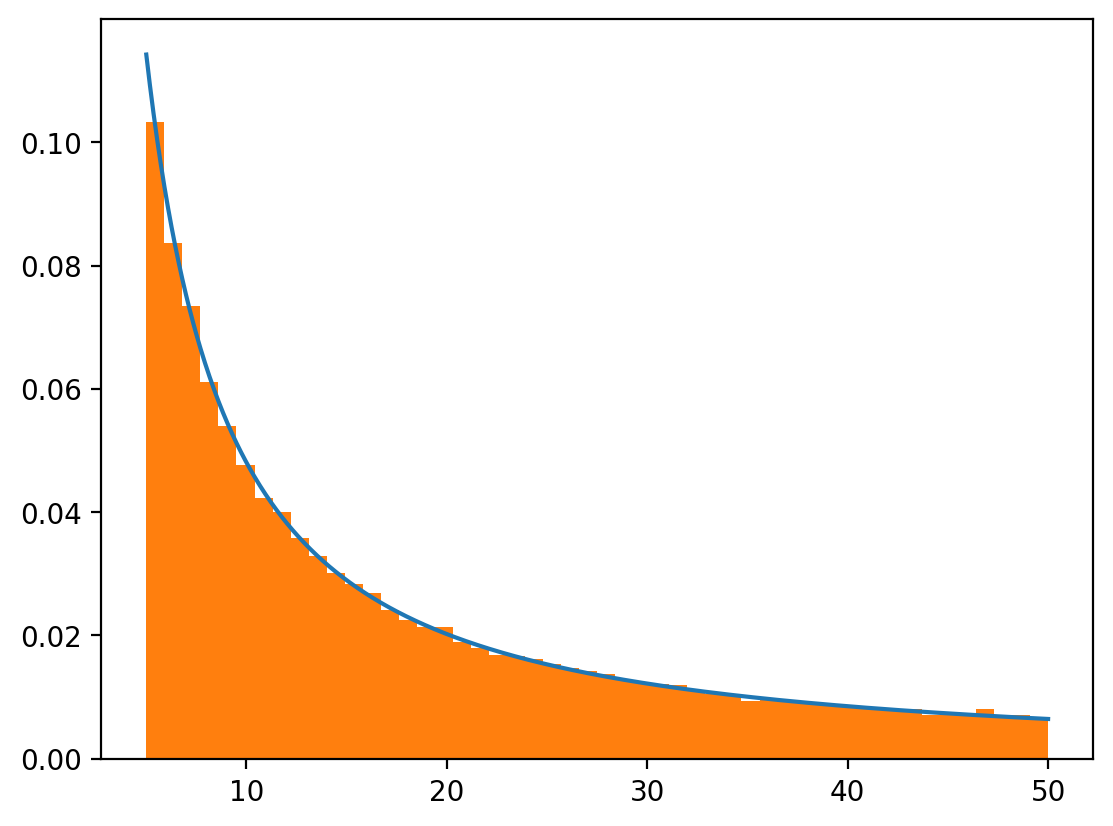

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import sympy

m = sympy.Symbol('m')
p = sympy.Symbol('p')
func = m**(-1.25)
norm = sympy.integrate(func, (m, 5, 50))
pdf = (1/norm)*m**(-1.25)


cdf = sympy.integrate(pdf,(m,5,m))

quantile = sympy.solvers.solve(cdf-p,m)

pdf = sympy.lambdify(m,pdf)
cdf = sympy.lambdify(m,cdf)
quantile = sympy.lambdify(p,quantile)

plt.plot(np.linspace(5,50,1000),pdf(np.linspace(5,50,1000)))

u = np.random.random(100000)
mdist = quantile(u)
plt.hist(mdist,bins=50,density=True)
plt.show()

In [6]:
m = sympy.Symbol('m',positive=True)
p = sympy.Symbol('p',positive=True)

func = m**(-(1.35))

norm = sympy.integrate(func, (m, 5, 50))
        
pdf = (1/norm)*m**(-(1.35))

cdf = sympy.integrate(pdf,(m,5,m))

        
quantile = sympy.solve(cdf-p,m)
try:
    quantile = sympy.lambdify(p,quantile[0])
except:
    quantile = sympy.lambdify(p,quantile)
print(quantile(0.01))

5.079896318680909


## Black hole object making!

In [103]:
import sys
sys.path.append('.')
from BBH_kick_sim import Simulator

In [104]:
params = {'cluster_mass':1e6,'imf_alpha':2.25,'radius':0.5,'rand_spin_type':'zero'}
test = Simulator.Simulator(params,print_missing=True)

'min_bh_star' not set, defaulting to 10
'bh_mass_frac' not set, defaulting to 0.5
'min_star' not set, defaulting to 0.8
'max_star' not set, defaulting to 100
'vel_thresh' not set, defaulting to 0.1
Setting up analytic mass distribution. This may take a while depending on your imf alpha
Done
Loaded NRSur7dq4Remnant fit.
Loaded NRSur3dq8Remnant fit.
Setup complete, Globular Cluster now has 14321 black holes.


In [105]:
test.begin_sim()
#Check distribution of q

No stop time specified, Running until 1 or 0 black holes remain
14321/14321 remaining
12986/14321 remaining
11666/14321 remaining
10356/14321 remaining
9059/14321 remaining
7772/14321 remaining
6483/14321 remaining
5217/14321 remaining
3975/14321 remaining
2264/14321 remaining
264/14321 remaining
Finished. Total Simulation time: 75.9827646113284
Total CPU time: 58.35796904563904


In [106]:
print(len(test.GC.BHs),'in system, ejected:',len(test.GC.ejected))
allBHs = test.GC.BHs + test.GC.ejected
print(len(allBHs))

0 in system, ejected: 4189
4189


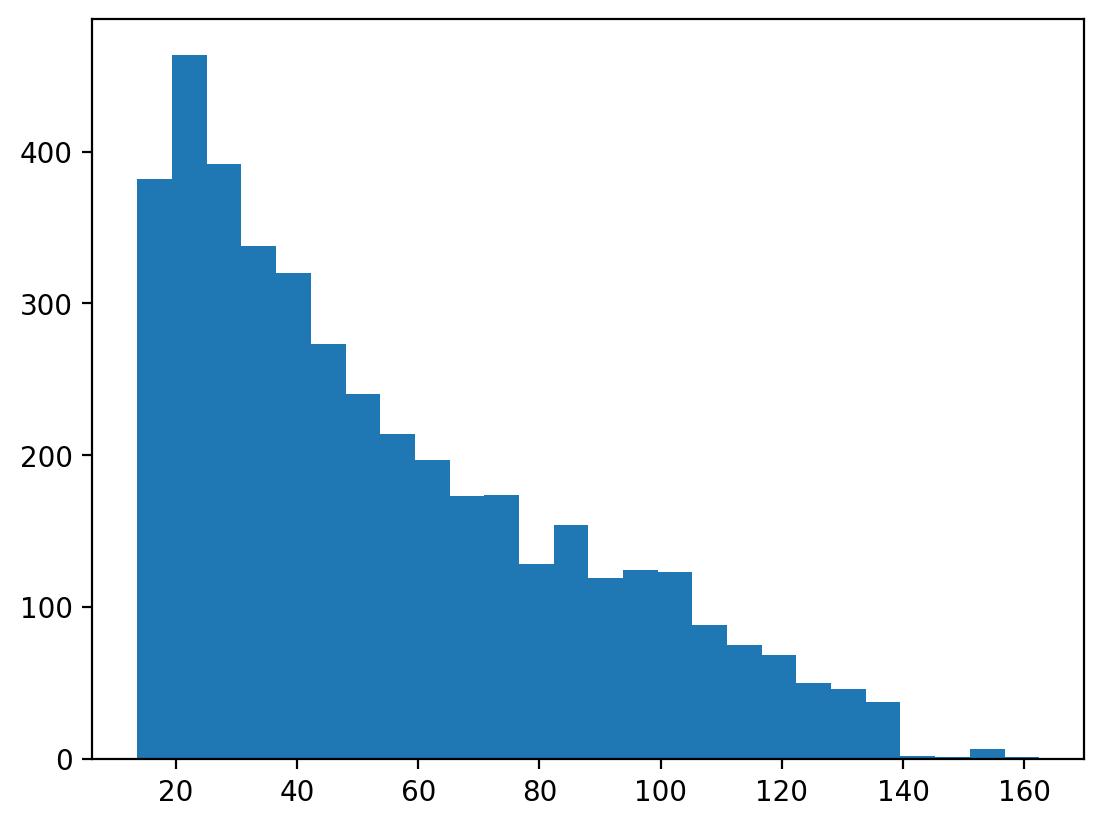

In [107]:
mall = [bh.m for bh in allBHs]
plt.hist(mall,bins='auto')
plt.show()

In [108]:
allBHs.sort(key=lambda b: -b.m)
for bh in allBHs:
    bh.printTree()

[M:162.439911,S_mag:0.871,v_mag:1140.269,v_imag:1140.269,t:46.298,t_i:46.298]
├── [M:90.580367,S_mag:0.687,v_mag:0.1,v_imag:0.309,t:46.298,t_i:0]
│   ├── [M:47.596148,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:47.593312,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:85.354094,S_mag:0.687,v_mag:0.1,v_imag:0.309,t:46.298,t_i:0]
    ├── [M:44.849963,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
    └── [M:44.84729,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:156.122149,S_mag:0.861,v_mag:300.251,v_imag:300.251,t:4.082,t_i:4.082]
├── [M:87.956711,S_mag:0.687,v_mag:0.1,v_imag:0.316,t:4.082,t_i:0]
│   ├── [M:46.219227,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:46.213073,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:80.457883,S_mag:0.687,v_mag:0.1,v_imag:0.316,t:4.082,t_i:0]
    ├── [M:42.278765,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
    └── [M:42.273136,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:155.31173,S_mag:0.864,v_mag:1153.352,v_imag:1153.352,t:2.27,t_i:2.27]


[M:105.835339,S_mag:0.796,v_mag:60.327,v_imag:60.327,t:18.929,t_i:18.929]
├── [M:93.735967,S_mag:0.687,v_mag:0.1,v_imag:0.313,t:18.929,t_i:0]
│   ├── [M:49.255485,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:49.250143,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:15.009999,S_mag:0.687,v_mag:0.1,v_imag:0.313,t:18.929,t_i:0]
    ├── [M:7.887311,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
    └── [M:7.886456,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:105.73046,S_mag:0.852,v_mag:784.506,v_imag:784.506,t:47.851,t_i:47.851]
├── [M:70.496502,S_mag:0.687,v_mag:0.1,v_imag:0.309,t:47.851,t_i:0]
│   ├── [M:37.042873,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:37.040774,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:42.755837,S_mag:0.687,v_mag:0.1,v_imag:0.309,t:47.851,t_i:0]
    ├── [M:22.46635,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
    └── [M:22.465075,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:105.531781,S_mag:0.8,v_mag:75.094,v_imag:75.094,t:55.794,t_i:55.794]
├── 

[M:89.856094,S_mag:0.759,v_mag:989.123,v_imag:989.123,t:0,t_i:0]
├── [M:61.929052,S_mag:0.687,v_mag:0.1,v_imag:0.32,t:0,t_i:0]
│   ├── [M:32.543055,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:32.537194,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:32.536204,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:89.720822,S_mag:0.845,v_mag:1166.133,v_imag:1166.133,t:9.273,t_i:9.273]
├── [M:63.180868,S_mag:0.687,v_mag:0.1,v_imag:0.315,t:9.273,t_i:0]
│   ├── [M:33.199956,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:33.195807,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:32.477812,S_mag:0.687,v_mag:0.1,v_imag:0.315,t:9.273,t_i:0]
    ├── [M:17.06627,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
    └── [M:17.064143,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:89.555032,S_mag:0.735,v_mag:902.479,v_imag:902.479,t:0,t_i:0]
├── [M:61.557849,S_mag:0.687,v_mag:0.1,v_imag:0.321,t:0,t_i:0]
│   ├── [M:32.348062,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:32.342095,S_mag:0.0,v_ma

[M:75.313268,S_mag:0.775,v_mag:2021.709,v_imag:2021.709,t:44.69,t_i:44.69]
├── [M:41.004457,S_mag:0.687,v_mag:0.1,v_imag:0.309,t:44.69,t_i:0]
│   ├── [M:21.546139,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:21.544789,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:38.996236,S_mag:0.687,v_mag:0.1,v_imag:0.309,t:44.69,t_i:0]
    ├── [M:20.490902,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
    └── [M:20.489619,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:75.288956,S_mag:0.823,v_mag:412.475,v_imag:412.475,t:0,t_i:0]
├── [M:52.317184,S_mag:0.687,v_mag:0.1,v_imag:0.364,t:0,t_i:0]
│   ├── [M:27.496844,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:27.482444,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:27.482129,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:75.26933,S_mag:0.786,v_mag:121.806,v_imag:121.806,t:25.291,t_i:25.291]
├── [M:65.291202,S_mag:0.687,v_mag:0.1,v_imag:0.312,t:25.291,t_i:0]
│   ├── [M:34.308413,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:34.30506

[M:64.251083,S_mag:0.808,v_mag:85.29,v_imag:85.29,t:0,t_i:0]
├── [M:44.525496,S_mag:0.687,v_mag:0.1,v_imag:0.322,t:0,t_i:0]
│   ├── [M:23.397838,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:23.393293,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:23.386307,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:64.206564,S_mag:0.832,v_mag:68.772,v_imag:68.772,t:0,t_i:0]
├── [M:44.69915,S_mag:0.687,v_mag:0.1,v_imag:0.376,t:0,t_i:0]
│   ├── [M:23.493907,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:23.479711,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:23.477419,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:64.163949,S_mag:0.778,v_mag:294.008,v_imag:294.008,t:74.595,t_i:74.595]
├── [M:50.36267,S_mag:0.687,v_mag:0.1,v_imag:0.304,t:74.595,t_i:0]
│   ├── [M:26.462703,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:26.462623,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:16.536217,S_mag:0.687,v_mag:0.1,v_imag:0.304,t:74.595,t_i:0]
    ├── [M:8.688836,S_mag:0.0,v_mag:0.0,v_i

[M:54.444657,S_mag:0.849,v_mag:173.962,v_imag:173.962,t:75.241,t_i:75.241]
├── [M:35.84673,S_mag:0.687,v_mag:0.1,v_imag:0.304,t:75.241,t_i:0]
│   ├── [M:18.835393,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:18.835363,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:22.555601,S_mag:0.687,v_mag:0.1,v_imag:0.304,t:75.241,t_i:0]
    ├── [M:11.85167,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
    └── [M:11.85165,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:54.401077,S_mag:0.761,v_mag:1439.325,v_imag:1439.325,t:0,t_i:0]
├── [M:37.507899,S_mag:0.687,v_mag:0.1,v_imag:0.327,t:0,t_i:0]
│   ├── [M:19.710586,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:19.705863,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:19.701826,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:54.35967,S_mag:0.87,v_mag:432.051,v_imag:432.051,t:45.774,t_i:45.774]
├── [M:32.627667,S_mag:0.687,v_mag:0.1,v_imag:0.309,t:45.774,t_i:0]
│   ├── [M:17.144466,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:17.14342

[M:46.513753,S_mag:0.837,v_mag:99.878,v_imag:99.878,t:58.63,t_i:58.63]
├── [M:38.112233,S_mag:0.687,v_mag:0.1,v_imag:0.307,t:58.63,t_i:0]
│   ├── [M:20.026127,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:20.025409,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:10.540437,S_mag:0.687,v_mag:0.1,v_imag:0.307,t:58.63,t_i:0]
    ├── [M:5.538487,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
    └── [M:5.538289,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:46.501874,S_mag:0.827,v_mag:105.039,v_imag:105.039,t:0,t_i:0]
├── [M:32.333933,S_mag:0.687,v_mag:0.1,v_imag:0.317,t:0,t_i:0]
│   ├── [M:16.99089,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:16.988322,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:16.987973,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:46.48926,S_mag:0.851,v_mag:669.34,v_imag:669.34,t:9.944,t_i:9.944]
├── [M:25.735693,S_mag:0.687,v_mag:0.1,v_imag:0.315,t:9.944,t_i:0]
│   ├── [M:13.523449,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:13.521779,S_mag:0.0,

[M:39.483496,S_mag:0.832,v_mag:67.003,v_imag:67.003,t:0,t_i:0]
├── [M:27.489096,S_mag:0.687,v_mag:0.1,v_imag:0.319,t:0,t_i:0]
│   ├── [M:14.44516,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:14.44269,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:14.440934,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:39.444709,S_mag:0.824,v_mag:489.949,v_imag:489.949,t:0,t_i:0]
├── [M:27.415423,S_mag:0.687,v_mag:0.1,v_imag:0.34,t:0,t_i:0]
│   ├── [M:14.407759,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:14.402669,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:14.400128,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:39.386711,S_mag:0.852,v_mag:892.447,v_imag:892.447,t:35.657,t_i:35.657]
├── [M:29.283326,S_mag:0.687,v_mag:0.1,v_imag:0.311,t:35.657,t_i:0]
│   ├── [M:15.387299,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:15.38608,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:12.579516,S_mag:0.687,v_mag:0.1,v_imag:0.311,t:35.657,t_i:0]
    ├── [M:6.610068,S_mag:0.0,v_mag:0.0,v

[M:33.307093,S_mag:0.802,v_mag:535.037,v_imag:535.037,t:0,t_i:0]
├── [M:23.068682,S_mag:0.687,v_mag:0.1,v_imag:0.327,t:0,t_i:0]
│   ├── [M:12.122701,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:12.119807,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:12.118597,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:33.299579,S_mag:0.824,v_mag:338.119,v_imag:338.119,t:0,t_i:0]
├── [M:23.143496,S_mag:0.687,v_mag:0.1,v_imag:0.327,t:0,t_i:0]
│   ├── [M:12.16204,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:12.159088,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:12.159022,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:33.286538,S_mag:0.718,v_mag:321.86,v_imag:321.86,t:0,t_i:0]
├── [M:22.823254,S_mag:0.687,v_mag:0.1,v_imag:0.321,t:0,t_i:0]
│   ├── [M:11.993426,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
│   └── [M:11.991167,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]
└── [M:11.990186,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]

[M:33.256013,S_mag:0.827,v_mag:113.729,v_imag:113.729,t:0,t_i

DuplicatedNodeIdError: Can't create node with ID '[M:9.878699,S_mag:0.0,v_mag:0.0,v_imag:0.0,t:0,t_i:0]'

In [102]:
from BBH_kick_sim.BlackHole import BlackHole
BH1 = BlackHole(1,np.array([0,0,0]),0,0)
BH2 = BlackHole(1,np.array([0,0,0]),0,0)

mf,chif,vf,t = test.collideBH(BH1,BH2)
print(np.sqrt(np.sum(np.square(chif))))

0.6865003753638543
